# Trivial Evolution for Spiking Neural Network 

## 1 Random Manifold Dataset

### 1.1 Data Preparation

In [4]:
import numpy as np
import torch 
from torch.utils.data import TensorDataset, DataLoader

import randman
from randman import Randman

device = 'cuda'

In [36]:
# Constants for data generation
NB_CLASSES = 2
NB_UNITS = 10 # number of input neurons / embedding dimensions
NB_STEPS = 50
NB_SAMPLES = 2000
SEED = 12

In [38]:
def standardize(x,eps=1e-7):
    # x's (which is actually y in the following code) shape will be [samples, units]
    # Therefore, 0-axis shows that the author standardize across all samples for each units
    mi,_ = x.min(0)
    ma,_ = x.max(0)
    return (x-mi)/(ma-mi+eps)

def make_spiking_dataset(nb_classes=10, nb_units=100, nb_steps=100, step_frac=1.0, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True, classification=True, seed=None):
    """ Generates event-based generalized spiking randman classification/regression dataset. 
    In this dataset each unit fires a fixed number of spikes. So ratebased or spike count based decoding won't work. 
    All the information is stored in the relative timing between spikes.
    For regression datasets the intrinsic manifold coordinates are returned for each target.
    Args: 
        nb_classes: The number of classes to generate
        nb_units: The number of units to assume
        nb_steps: The number of time steps to assume
        step_frac: Fraction of time steps from beginning of each to contain spikes (default 1.0)
        nb_spikes: The number of spikes per unit
        nb_samples: Number of samples from each manifold per class
        alpha: Randman smoothness parameter
        shuffe: Whether to shuffle the dataset
        classification: Whether to generate a classification (default) or regression dataset
        seed: The random seed (default: None)
    Returns: 
        A tuple of data,labels. The data is structured as numpy array 
        (sample x event x 2 ) where the last dimension contains    
        the relative [0,1] (time,unit) coordinates and labels.
    """
  
    data = []
    labels = []
    targets = []

    if SEED is not None:
        np.random.seed(SEED)
    
    max_value = np.iinfo(int).max
    randman_seeds = np.random.randint(max_value, size=(nb_classes,nb_spikes) )

    for k in range(nb_classes):
        x = np.random.rand(nb_samples,dim_manifold)
        
        # The following code shows that if more than one spike, different spikes, even for the same unit, are generated by independent mappings 
        submans = [ randman.Randman(nb_units, dim_manifold, alpha=alpha, seed=randman_seeds[k,i]) for i in range(nb_spikes) ]
        units = []
        times = []
        for i,rm in enumerate(submans):
            y = rm.eval_manifold(x)
            y = standardize(y)
            units.append(np.repeat(np.arange(nb_units).reshape(1,-1),nb_samples,axis=0))
            times.append(y.numpy())

        units = np.concatenate(units,axis=1)
        times = np.concatenate(times,axis=1)
        events = np.stack([times,units],axis=2)
        data.append(events)
        labels.append(k*np.ones(len(units)))
        targets.append(x)

    data = np.concatenate(data, axis=0)
    labels = np.array(np.concatenate(labels, axis=0), dtype=int)
    targets = np.concatenate(targets, axis=0)

    if shuffle:
        idx = np.arange(len(data))
        np.random.shuffle(idx)
        data = data[idx]
        labels = labels[idx]
        targets = targets[idx]

    data[:,:,0] *= nb_steps*step_frac
    # data = np.array(data, dtype=int)

    if classification:
        return data, labels
    else:
        return data, targets
    
def events_to_spike_train(data):
    """convert the data generated from manifold to spike train form

    Args:
        data (array): shape is [samples, nb_events, 2]

    Returns:
        spike_train: shape is [nb_samples, nb_time_steps, units]
    """
    
    # astyle() will discard the decimal to give integer timestep
    spike_steps = data[:, :, 0].astype(int)
    spike_units = data[:, :, 1].astype(int)
    # These will be the indices to entrices in the spike train to be set to 1
    
    # Use the index on spike train matrix [samples, steps, units]
    spike_train = np.zeros((data.shape[0], NB_STEPS, NB_UNITS))
    sample_indicies = np.expand_dims(np.arange(data.shape[0]), -1)
    spike_train[sample_indicies, spike_steps, spike_units] = 1
    
    return spike_train    

def get_randman_dataset():
    """generate a TensorDataset encapsulated x and y, where x is spike trains

    Returns:
        TensorDataset: [nb_samples, time_steps, units] and [nb_samples]
    """
    data, label = make_spiking_dataset(NB_CLASSES, NB_UNITS, NB_STEPS, nb_spikes=1, nb_samples=NB_SAMPLES)
    spike_train = events_to_spike_train(data)
    
    spike_train = torch.Tensor(spike_train).to(device)
    label = torch.Tensor(label).to(device)
    
    # encapulate using Torch.Dataset
    dataset = TensorDataset(spike_train, label)
    
    return dataset

In [7]:
ds = get_randman_dataset()

### 1.2 Model

In [9]:
import snntorch as snn
import torch
import torch.nn as nn

In [10]:
# Hyperparameters
NB_HIDDEN_UNITS = int(NB_UNITS * 1.5)
BETA = 0.85 # This can also be obtained using exp(-delta_t / tau)

Note: SnnTorch uses time-first dimensionality for the input $x$: [time, batch_size, feature_num].

In [11]:
class RandmanSNN(nn.Module):
    '''
    Spiking Neural Network with one hidden layer.
    '''
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(NB_UNITS, NB_HIDDEN_UNITS)
        self.lif1 = snn.Leaky(beta = BETA, reset_mechanism = 'subtract')
        self.fc2 = nn.Linear(NB_HIDDEN_UNITS, NB_CLASSES)
        self.lif2 = snn.Leaky(beta = BETA, reset_mechanism = 'subtract')
        
    def init_state(self):
        # init recordings
        self.mem1_rec = []
        self.mem2_rec = []
        self.spike1_rec = []
        self.spike2_rec = []
        
    def forward(self, x):
        # x is given in [batch_size, time_steps, units], but SnnTorch uses [time, batch_size, nb_units] for x
        # So reshape to whatSnn Torch wants by switching first two axis
        x = x.transpose(0, 1)        
        
        # Initialize membrane potential to 0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        self.init_state()
               
        for step in range(NB_STEPS):
            # Input spike trains are weighted by the synaptic weights to produce current to the first neuron
            cur1 = self.fc1(x[step]) # can pull out from loop to do all at once? 
            
            # lif1 accumulates the current and update its membrane potential, decide whether it spikes
            spike1, mem1 = self.lif1(cur1, mem1)
            
            # Similar to cur1 and lif1 operations
            cur2 = self.fc2(spike1)
            spike2, mem2 = self.lif2(cur2)
            
            # Write to records
            self.mem1_rec.append(mem1)
            self.spike1_rec.append(spike1)
            self.mem2_rec.append(mem2)
            self.spike2_rec.append(spike2)
            
        # The output is of shape [time_steps, batch_size, classes]
        return torch.stack(self.spike2_rec, dim=0)

In [12]:
def spike_to_label(spike_train, scheme = 'most_spikes'):
    """Convert spike train to the label in one-hot encoded class

    Args:
        spike_train (tensor): spike train with shape [time_steps, batch_size, classes]
        scheme(string): options: 'most_spikes' and 'first_spike'
        
    Return:
        one label for each sample: [batch_size,]
    """
    if scheme == 'most_spikes':
        # count number of spikes along the time_steps dimension. Result is [batch_size, classes]
        spike_counts = spike_train.count_nonzero(dim=0)
        
        # pick the index of along the clsses dimension
        result = spike_counts.argmax(dim=-1)
    else:
        raise Exception('Undefined Scheme')
    
    return result

def spike_count(spike_train):
    """count number of spikes for each spike train

    Args:
        spike_train (tensor): shape v[time_steps, batch_size, classes]

    Returns:
        tensor: [batch_size, classes]
    """
    return spike_train.count_nonzero(dim=0)

### 1.3 Evolution Strategy

In [39]:
import torch.optim as optim

def log_grad_wrt_mean(mean, std, v):
    ''' calculate the gradient of the log of the loss function with respect to the mean'''
    return (v - mean) / std**2

class ESParameter:    
    def __init__(self, para_means, para_std=1, Optimizer = optim.Adam):
        self.means = para_means
        self.means.grad = torch.zeros(self.means.shape).to(device)
        self.STD = para_std
        self.samples = None
        self.optimizer = Optimizer([self.means], lr=0.01)
        
    def sample(self, sample_size):
        """draw samples for each parameter from normal distribution with self.means and self.STD.

        Args:
            sample_size (int): number of samples

        Returns:
            tensor: shape [sample_size, ...shape of parameters...]
        """
        # insert sample_size dimension
        sample_means = self.means.unsqueeze(0)
        
        # the shape is for repeat(), it is [sample_size, 1, ... ,1]
        shape = [1] * len(sample_means.shape)
        shape[0] = sample_size
        
        # duplicate means along the sample size dimension
        sample_means = sample_means.repeat(shape)
        
        # draw samples
        self.samples = torch.normal(mean=sample_means, std=self.STD)
        
        return self.samples
    
    def gradient_descent(self, loss):
        """ Move the means of the parameters against gradient. The gradient is calculated based on loss.
            And self.optimizer will be used to step.

        Args:
            loss (Tensor): with shape [nb_samples,]
        """
        # shape of self.samples = [nb_samples, ...weight shape...]
        
        # Result is the gradients for each prameter, so the shape should match
        # with the parameters, which is [...weight shape...].
        
        # Calculate the gradient for each sample weight, so log_grad will have [nb_samples, ...weight shape...]
        log_grad = log_grad_wrt_mean(self.means, self.STD, self.samples)
        
        ## Calculate the sum of log_grad = [nb_samples, ...weight shape...] and loss = [nb_samples,]
        # Reshape loss for broadcasting to [nb_samples, 1....1]
        new_shape = [loss.shape[0]] + [1] * (len(log_grad.shape) - 1)
        
        # grad is now [nb_samples, ...weight shape...]
        grad = log_grad * loss.reshape(new_shape)
        
        # Take average across sample dimension to estimate the expectation
        self.means.grad = grad.mean(dim=0)
        
        # step the optimizer
        self.optimizer.step()
        

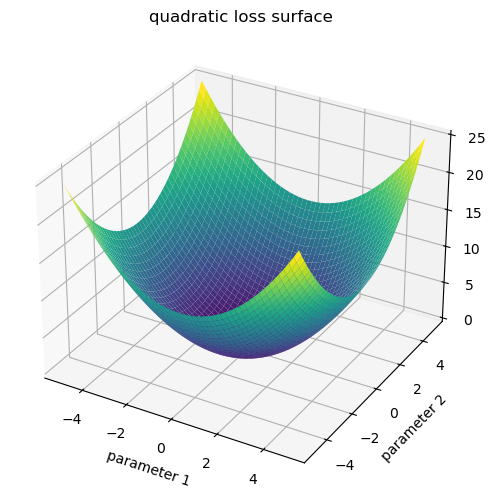

In [14]:
import matplotlib.pyplot as plt
def plot_landscape():
    # Create a meshgrid for X and Y
    x = np.linspace(-5, 5, 50)
    y = np.linspace(-5, 5, 50)
    X, Y = np.meshgrid(x, y)

    # Define a function for Z
    Z = (X**2 + Y**2) / 2

    # Create a figure and 3D axis
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis')

    # Labels
    ax.set_xlabel('parameter 1')
    ax.set_ylabel('parameter 2')

    ax.set_title('quadratic loss surface')

    # Show the plot
    # plt.tight_layout()
    plt.show()
    
plot_landscape()

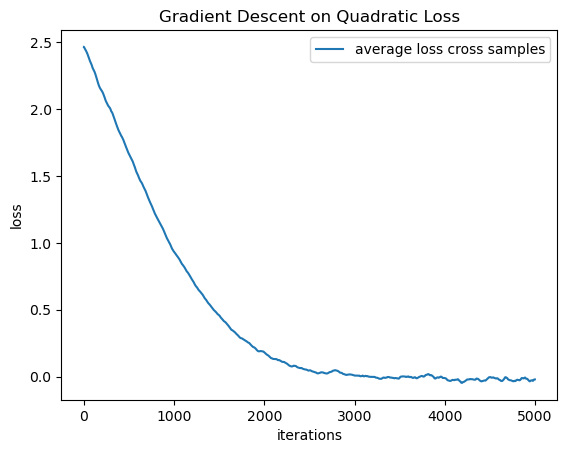

In [53]:
import matplotlib.pyplot as plt
# POTENTIAL VISUALIZATION!!!
# The simulation in ES is just a function: param_samples -> loss
def quadratic_landscape(params):
    # params is of dimension: [nb_samples, ...params shape....]
    # so number of params is nubmer of elements in params shape
    nb_params = torch.numel(params[0])
    
    # the dimensions to sum are all but the first dim
    dims_to_sum = tuple(range(1, params.dim()))
    
    # normalize by number of parameters
    return torch.sum(params ** 2, dim=dims_to_sum) / nb_params 

def gradient_descent_for_dummy(param_to_loss):
    param_shape = [4,4]
    param_scale = 5
    param = ESParameter(torch.rand(param_shape).to(device) * param_scale, Optimizer=optim.Adam)
    
    
    average_loss_cross_samples = []
    for _ in range(5000):
        param_samples = param.sample(sample_size=30)        
        
        # loss shape: [nb_samples,]
        loss = param_to_loss(param_samples)
        
        param.gradient_descent(loss)
        average_loss_cross_samples.append(torch.mean(param.means).cpu())   
    
    plt.plot(average_loss_cross_samples, label='average loss cross samples')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.title('Gradient Descent on Quadratic Loss')
    plt.legend()
    plt.show()
    
gradient_descent_for_dummy(quadratic_landscape)

Note: Adjust param scale to see effect.

Possible direction: use more complex landscape with local mins and saddle points. My guess is that the sampling should overcome this problem because it has a wide vision than single point

### 1.4 Training

Technically, I should run all the data samples for each of the model sample. Later I can do batch instead of whole dataset.

TODO on train function:
- ~~add vallidation loop after each train. How to validate though - use the mean to produce model maybe.~~
- Training the fc1 layer first, then loop through all layers.
- write function to encapsulate training across all batches, and possibly other loops.
- If still not performing well
    - try Spike Count-Based Hinge Loss
    - look back at the paper and try the one parameter model it mentioned. Then scale back to this task.

In [34]:
def _run_over_dataset(dataloader, model, loss_fn):
    sample_loss = 0
    sample_correct = 0
    # run the model for each batch 
    for x, y in dataloader:
        # shape: [time_steps, batch_size, classes]
        out_spikes = model(x)
        
        # shape: [batch_size, classes], the classes dimension can be treated as logits
        pred_spike_counts = spike_count(out_spikes)                
        
        # Crossentropy loss function requires pred.dtype=float32 and y.dtype=int64, maybe other loss have diff requirements? 
        sample_loss += loss_fn(pred_spike_counts.float(), y.long())
        
        # add number of correct in this batch 
        sample_correct += (spike_to_label(out_spikes) == y).sum()
    average_loss = sample_loss / len(dataloader)
    average_correct = sample_correct / len(dataloader.dataset)
    return average_loss, average_correct        

def _run_model_sample_on_batch(param_layers, x, y, loss_fn):
    model = RandmanSNN().to(device)
    for i, layer in enumerate(model.parameters()):
        layer.data.copy_(param_layers[i])
    
    # shape: [time_steps, batch_size, classes]
    out_spikes = model(x)
    
    # shape: [batch_size, classes], the classes dimension can be treated as logits
    pred_spike_counts = spike_count(out_spikes)  
    
    loss = loss_fn(pred_spike_counts.float(), y.long())
    correct = (spike_to_label(out_spikes) == y).sum()
    
    return loss, correct
    
    

def train(dataloader, loss_fn, nb_model_samples=30, nb_epochs = 100):       
    with torch.no_grad(): # ES doesn't need gradient 
    
        # Use a instance of model to initialize ESParameter
        # fc1_param = ESParameter(RandmanSNN().fc1.weight.clone().detach().to(device))
        esparams = []
        for param in RandmanSNN().parameters():
            esparams.append(ESParameter(param.clone().detach().to(device),para_std=0.2))
        
        total_loss = []
        total_acc = []
        for epoch in range(nb_epochs):      
            # Treat each batch as if it's a whole dataset, so update after running through the batch
            for x, y in dataloader:      
                # keep track of stats for each model sample          
                batch_loss = []
                batch_correct = 0
                
                # generate prams for each tracked params
                model_param_samples = [] # [nb_parts, nb_sample, ...param...]
                for layer_param in esparams: model_param_samples.append(layer_param.sample(nb_model_samples))
                # loop through all the model samples 
                for i in range(nb_model_samples):
                    # param_layer take the i-th sample for each layer: [nb_parts, ...param...]
                    param_layers = [layer_samples[i] for layer_samples in model_param_samples]
                    loss, correct = _run_model_sample_on_batch(param_layers, x, y, loss_fn)
                                      
                    batch_loss.append(loss)           
                    batch_correct += correct
                    
                batch_loss = torch.stack(batch_loss)
                for param in esparams: param.gradient_descent(batch_loss)
                print(f'epoch {epoch}: batch loss:{batch_loss.mean():.2f}, batch accuracy:{batch_correct / (len(y) * nb_model_samples):.2f}')  
                total_loss.append(batch_loss.mean())
                total_acc.append(batch_correct / (len(y) * nb_model_samples))
                
    return total_loss, total_acc

In [ ]:
class SpikeHingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, pred, target):
        """
        pred: Tensor of shape (batch_size, num_classes) - spike counts
        target: Tensor of shape (batch_size,) - correct class indices
        """
        batch_size, num_classes = pred.shape

        # Get spike count of the correct class for each sample
        correct_spike_counts = pred[torch.arange(batch_size), target]  # Shape: (batch_size,)

        # Create a mask to ignore the correct class in comparisons
        mask = torch.ones_like(pred, dtype=torch.bool)
        mask[torch.arange(batch_size), target] = False

        # Get the max spike count among incorrect classes
        max_incorrect_spikes, _ = pred.masked_fill(~mask, float('-inf')).max(dim=1)  # Shape: (batch_size,)

        # Compute hinge loss: max(0, S_i - S_y + margin)
        losses = torch.clamp(max_incorrect_spikes - correct_spike_counts + self.margin, min=0)

        return losses.mean()

In [46]:
def _trivial_loss(pred, label):
    print(f'type of pred: {pred.dtype}, type of label: {label[0].dtype}')
    return torch.Tensor([1]).to(device)

# def chatgpt_loss(pred, label):
#     # pred: [nb_batches, nb_classes], 



def test_train():
    dataloader = DataLoader(get_randman_dataset(),batch_size=256,shuffle=True)
    
    loss_fn = nn.CrossEntropyLoss()
    # loss_fn = SpikeHingeLoss()
    return train(dataloader, loss_fn,nb_epochs=10)

    
total_loss, total_acc = test_train()

epoch 0: batch loss:3.55, batch accuracy:0.50
epoch 0: batch loss:4.74, batch accuracy:0.51
epoch 0: batch loss:4.10, batch accuracy:0.51
epoch 0: batch loss:3.15, batch accuracy:0.50
epoch 0: batch loss:3.12, batch accuracy:0.48
epoch 0: batch loss:3.84, batch accuracy:0.52
epoch 0: batch loss:3.38, batch accuracy:0.48
epoch 0: batch loss:3.30, batch accuracy:0.50
epoch 0: batch loss:2.78, batch accuracy:0.50
epoch 0: batch loss:3.69, batch accuracy:0.53
epoch 0: batch loss:3.04, batch accuracy:0.49
epoch 0: batch loss:2.31, batch accuracy:0.49
epoch 0: batch loss:2.34, batch accuracy:0.51
epoch 0: batch loss:2.62, batch accuracy:0.51
epoch 0: batch loss:2.29, batch accuracy:0.49
epoch 0: batch loss:2.56, batch accuracy:0.49
epoch 1: batch loss:3.06, batch accuracy:0.48
epoch 1: batch loss:2.51, batch accuracy:0.52
epoch 1: batch loss:2.52, batch accuracy:0.50
epoch 1: batch loss:2.37, batch accuracy:0.47
epoch 1: batch loss:3.27, batch accuracy:0.47
epoch 1: batch loss:2.21, batch ac

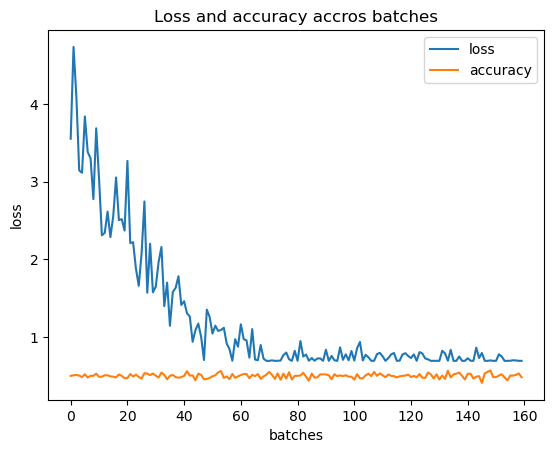

In [48]:
def plot_es_performance():
    plt.plot(torch.stack(total_loss).cpu(), label='loss')
    plt.plot(torch.stack(total_acc).cpu(), label='accuracy')
    plt.xlabel('batches')
    plt.ylabel('loss')
    
    plt.title('Loss and accuracy accros batches')
    plt.legend()
    plt.show()

plot_es_performance()